In [1]:
import pandas as pd
import os

In [2]:
# Define file prefixes in a list
file_prefixes = [
    "../English/Adhd_eng/",
    "../English/Anxiety_eng/",
    "../English/Asd_eng/",
    "../English/Bipolar_eng/",
    "../English/Control_eng/",
    "../English/Depression_eng/",
    "../English/Eating_eng/",
    "../English/Ocd_eng/",
    "../English/Ptsd_eng/",
    "../English/Schizophrenia_eng/",
    "../Spanish/Adhd_esp/",
    "../Spanish/Anxiety_esp/",
    "../Spanish/Asd_esp/",
    "../Spanish/Bipolar_esp/",
    "../Spanish/Control_esp/",
    "../Spanish/Depression_esp/",
    "../Spanish/Eating_esp/",
    "../Spanish/Ocd_esp/",
    "../Spanish/Ptsd_esp/",
    "../Spanish/Schizophrenia_esp/"
]


In [3]:
# Initialize a list to hold all DataFrames
dataframes = []

# Loop through each prefix and read CSV files
for prefix in file_prefixes:
    # Determine the language based on the prefix
    language = 'English' if 'English' in prefix else 'Spanish'
    
    # Create full paths and read CSV files into DataFrames
    full_paths = [os.path.join(prefix, file) for file in os.listdir(prefix) if file.endswith('.csv')]
    
    for file in full_paths:
        df = pd.read_csv(file)

        # This is for a bug where the classes are named differently in English and Spanish
        if (prefix == "../English/Eating_eng/"):
            df["class"] = "EATING"
        elif (prefix == "../English/Asd_eng/"):
            df["class"] = "ASD"

        df['language'] = language  # Add a new column for the language
        dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(dataframes, ignore_index=True)

In [4]:
all_data

,class,tweet_id,day,time,tweet,tweet_favorite_count,tweet_retweet_count,tweet_source,user_id,user_followers_count,user_friends_count,user_listed_count,user_statuses_count,language
0,ADHD,1467992264270045193,2021-12-06,23:00:04,"""Miss this HTTPURL""",0,0,Twitter Web App,758856143460458497,565,383,2,2092,English
1,ADHD,1467990574879981568,2021-12-06,22:53:21,"""The doctor accepted my application and I have...",0,0,Twitter Web App,758856143460458497,565,383,2,2092,English
2,ADHD,1464801014159228932,2021-11-28,03:39:11,"""Im back again yay HTTPURL""",1,0,Twitter Web App,758856143460458497,565,383,2,2092,English
3,ADHD,1402116346016632832,2021-06-08,04:12:41,"""Thats great though I hope my mutuals are in r...",1,0,Twitter for iPhone,758856143460458497,565,383,2,2092,English
4,ADHD,1402116229494710277,2021-06-08,04:12:13,"""Damn I havent come on here since last year an...",1,0,Twitter for iPhone,758856143460458497,565,383,2,2092,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7768859,SCHIZOPHRENIA,1390746266133573633,2021-05-07,19:12:03,@USUARIO Estás meditando? A mí me pasaba hasta...,1,0,Twitter for iPhone,53979710,2717,253,19,57380,Spanish
7768860,SCHIZOPHRENIA,1390705930568966148,2021-05-07,16:31:46,Tú tan la mente todo lo cura y yo tan la mente...,16,1,Twitter Web App,53979710,2717,253,19,57380,Spanish
7768861,SCHIZOPHRENIA,1390685718553432065,2021-05-07,15:11:27,@USUARIO O lo que es lo mismo: Puebla.,1,0,Twitter for iPhone,53979710,2717,253,19,57380,Spanish
7768862,SCHIZOPHRENIA,1390684528214151173,2021-05-07,15:06:43,Ya está en sus inbox la newsletter de la seman...,9,3,Twitter Web App,53979710,2717,253,19,57380,Spanish


In [5]:
total = len(all_data)
class_counts = all_data["class"].value_counts()
percentages = (class_counts / total * 100).round(2)
print("\nClass distribution (percentage of total data):")
for class_name, percentage in percentages.items():
    print(f"{class_name}: {percentage}%")


Class distribution (percentage of total data):
CONTROL: 54.66%
ADHD: 14.86%
DEPRESSION: 8.71%
ANXIETY: 5.83%
ASD: 4.61%
BIPOLAR: 3.28%
PTSD: 3.14%
OCD: 2.22%
EATING: 1.82%
SCHIZOPHRENIA: 0.87%


In [6]:
import re
from concurrent.futures import ProcessPoolExecutor

In [7]:
# Define patterns
USER_PATTERN = re.compile(r'@\w+')
SPECIAL_CHARS = re.compile(r'[^a-zA-Z0-9\sáéíóúüñÁÉÍÓÚÜÑ]') # Include spanish characters
REPEAT_CHARS = re.compile(r'(\w)\1{2,}')
REPEAT_NON_WORD = re.compile(r'(\W)\1{2,}')
EXTRA_SPACES = re.compile(r'\s+')

def clean_tweet(tweet):
    try:
        # Remove URLs and user mentions
        tweet = USER_PATTERN.sub('', tweet)
        
        # Convert to lowercase
        tweet = tweet.lower()
        
        tweet = re.sub('httpurl', '', tweet)

        # Remove special characters and repeating characters
        tweet = SPECIAL_CHARS.sub('', tweet)
        tweet = REPEAT_CHARS.sub(r'\1', tweet)
        tweet = REPEAT_NON_WORD.sub(r'\1', tweet)
        
        # Split into words
        words = tweet.split()
        
        # Check if tweet is too short
        if len(words) < 3:
            return None
            
        # Join words and clean up spaces
        tweet = EXTRA_SPACES.sub(' ', ' '.join(words)).strip()
        
        return tweet if tweet else None
        
    except Exception:
        return None


In [8]:
def process_tweets(tweets, num_workers=None):
    # Use optimal number of workers
    if num_workers is None:
        num_workers = min(32, os.cpu_count() + 4)
    
    # Process in larger chunks for better performance
    chunk_size = max(1000, len(tweets) // (num_workers * 2))
    
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        cleaned_tweets = list(executor.map(clean_tweet, tweets, chunksize=chunk_size))
    
    return cleaned_tweets

In [9]:
all_data["tweet"].loc[1010:1020].tolist()

['"henlo"',
 '"I\'m just hear to find out if I have more characters  I found out I do not"',
 '"Relationship pending"',
 '"He\'s so cute I haven\'t been sad in while"',
 '"I like boy"',
 '"@USER What u say"',
 '"I wish I stayed home"',
 '"he\'s funny HTTPURL"',
 '"I would be here for this I\'m not even gonna pretend I wouldn\'t be HTTPURL"',
 '"Henlo i am lone ly"',
 '"call me dramatic but I would absolutely rather be emotionally distant than have a melodramatic heartbreak"']

In [10]:
process_tweets(all_data["tweet"].loc[1010:1020])

[None,
 'im just hear to find out if i have more characters i found out i do not',
 None,
 'hes so cute i havent been sad in while',
 'i like boy',
 'what u say',
 'i wish i stayed home',
 None,
 'i would be here for this im not even gonna pretend i wouldnt be',
 'henlo i am lone ly',
 'call me dramatic but i would absolutely rather be emotionally distant than have a melodramatic heartbreak']

In [11]:
all_data["tweet"].loc[6_001_000:6_002_000].tolist()

['mañana es mi cumple q me van a regalar',
 '@USUARIO comoooo',
 '@USUARIO si no se pq ayuds',
 'les aparece q los sigo?',
 'me siento mal otra vez jejejj',
 'para que reactivee',
 'hola jaja',
 'buen diaaaa',
 'me quiefo matqr',
 '@USUARIO todavia no',
 '@USUARIO creo q lo tenia atado con una colita',
 'FELIX QIE',
 'BUEN DKA',
 'felix donde estas te extraño',
 '@USUARIO pasa xfa',
 'me enferme y el martes me tengo q vacunar 😬',
 'te amo tanto xfavoooor HTTPURL',
 'recién me levanto de la siestita buen dia',
 'quiero un bbokari',
 'pq asqueroso??? fea HTTPURL',
 '@USUARIO la segunda',
 '@USUARIO fua quiero',
 '@USUARIO hivamos',
 'voten x seungmin!! es la segunda opción HTTPURL',
 '@USUARIO apa q me estas queriendo decir',
 'te mereces lo mejor del mundo mi amorcito HTTPURL',
 'REVIEN VUELVO DEL COL2GI9 GANARON???',
 '@USUARIO quiero',
 '@USUARIO hablale',
 'estaba hablando en ingles con mi reflejo y justo entro mi hermana me miro asi 😐🤨 plss',
 '@USUARIO cuidate mucho &lt;3',
 '@USUA

In [12]:
process_tweets(all_data["tweet"].loc[6_001_000:6_002_000].tolist())

['mañana es mi cumple q me van a regalar',
 None,
 'si no se pq ayuds',
 'les aparece q los sigo',
 'me siento mal otra vez jejejj',
 'para que reactivee',
 None,
 None,
 'me quiefo matqr',
 None,
 'creo q lo tenia atado con una colita',
 None,
 None,
 'felix donde estas te extraño',
 None,
 'me enferme y el martes me tengo q vacunar',
 'te amo tanto xfavor',
 'recién me levanto de la siestita buen dia',
 'quiero un bbokari',
 'pq asqueroso fea',
 None,
 None,
 None,
 'voten x seungmin es la segunda opción',
 'apa q me estas queriendo decir',
 'te mereces lo mejor del mundo mi amorcito',
 'revien vuelvo del col2gi9 ganaron',
 None,
 None,
 'estaba hablando en ingles con mi reflejo y justo entro mi hermana me miro asi plss',
 'cuidate mucho lt3',
 'los amo tanto lt33',
 'lo están y mucho lt3',
 None,
 'me siento sola es momento de llorqr',
 None,
 'voy a desactivar chau',
 None,
 None,
 None,
 None,
 'ayq buenoo q te vaya bien entonces lt3',
 'noo cande falta x hoy',
 'sii ya me dejaron

In [13]:
# Clean all tweets
cleaned_tweets = process_tweets(all_data['tweet'])

In [14]:
# Create new DataFrame with cleaned tweets and classes
final_data = pd.DataFrame({
    'tweet': cleaned_tweets,
    'class': all_data['class'],
    'language': all_data['language'],
    
}).dropna()

# Save to CSV
final_data.to_csv('../cleaned_tweets.csv', index=False)

In [15]:
final_data

,tweet,class,language
1,the doctor accepted my application and i have ...,ADHD,English
2,im back again yay,ADHD,English
3,thats great though i hope my mutuals are in re...,ADHD,English
4,damn i havent come on here since last year and...,ADHD,English
5,hi im back,ADHD,English
...,...,...,...
7768859,estás meditando a mí me pasaba hasta que me de...,SCHIZOPHRENIA,Spanish
7768860,tú tan la mente todo lo cura y yo tan la mente...,SCHIZOPHRENIA,Spanish
7768861,o lo que es lo mismo puebla,SCHIZOPHRENIA,Spanish
7768862,ya está en sus inbox la newsletter de la seman...,SCHIZOPHRENIA,Spanish


In [16]:
max_length = final_data["tweet"].str.len().max()
avg_length = final_data["tweet"].str.len().mean()

print(f"Max tweet length: {max_length}")
print(f"Average tweet length: {avg_length}")

Max tweet length: 498
Average tweet length: 92.25793253534628


In [17]:
percentile = final_data["tweet"].str.len().quantile(0.90)
print(f"90th percentile tweet length: {percentile}")

90th percentile tweet length: 218.0


In [18]:
import matplotlib.pyplot as plt

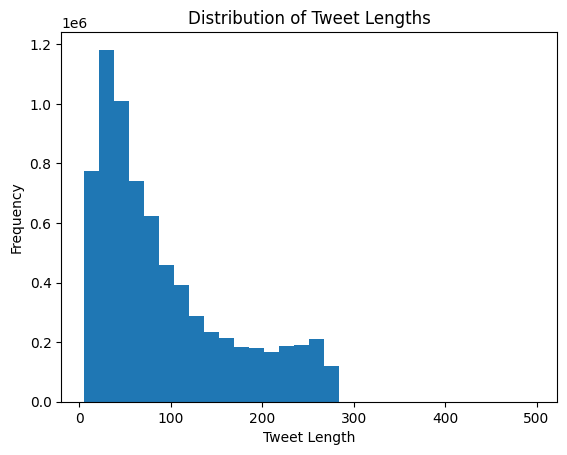

In [19]:
plt.hist(final_data["tweet"].str.len(), bins=30)
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths")
plt.show()

Processed 0 texts
Processed 100000 texts
Processed 200000 texts
Processed 300000 texts
Processed 400000 texts
Processed 500000 texts
Processed 600000 texts
Processed 700000 texts
Processed 800000 texts
Processed 900000 texts
Processed 1000000 texts
Processed 1100000 texts
Processed 1200000 texts
Processed 1300000 texts
Processed 1400000 texts
Processed 1500000 texts
Processed 1600000 texts
Processed 1700000 texts
Processed 1800000 texts
Processed 1900000 texts
Processed 2000000 texts
Processed 2100000 texts
Processed 2200000 texts
Processed 2300000 texts
Processed 2400000 texts
Processed 2500000 texts
Processed 2600000 texts
Processed 2700000 texts
Processed 2800000 texts
Processed 2900000 texts
Processed 3000000 texts
Processed 3100000 texts
Processed 3200000 texts
Processed 3300000 texts
Processed 3400000 texts
Processed 3500000 texts
Processed 3600000 texts
Processed 3700000 texts
Processed 3800000 texts
Processed 3900000 texts
Processed 4000000 texts
Processed 4100000 texts
Process

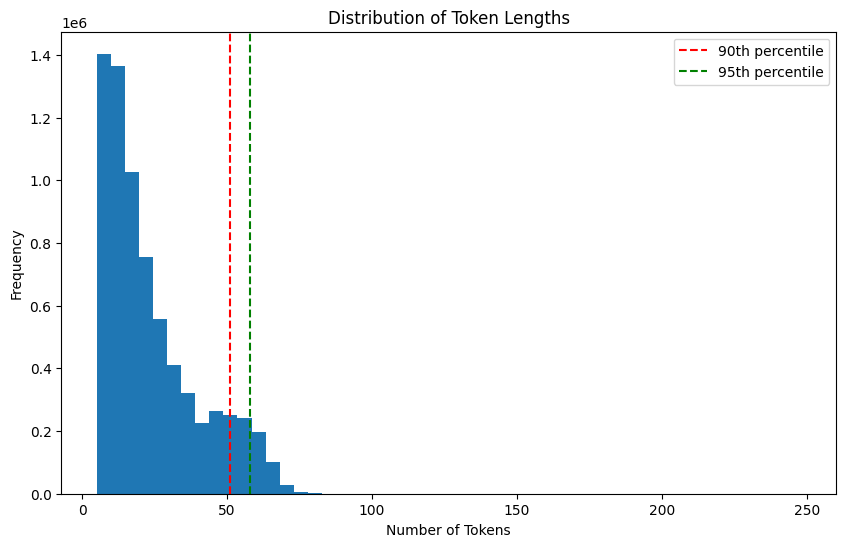

In [24]:
from transformers import XLMRobertaTokenizer
import numpy as np

# Initialize tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Function to get token lengths for a batch of texts
def get_token_lengths(texts, batch_size=1000):
    lengths = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist()
        encoded = tokenizer(batch, truncation=False, padding=False)
        batch_lengths = [len(seq) for seq in encoded['input_ids']]
        lengths.extend(batch_lengths)
        
        if i % 100000 == 0:
            print(f"Processed {i} texts")
    
    return lengths

# Get token lengths for all tweets
token_lengths = get_token_lengths(final_data['tweet'])

# Calculate statistics
mean_len = np.mean(token_lengths)
median_len = np.median(token_lengths)
p90_len = np.percentile(token_lengths, 90)
p95_len = np.percentile(token_lengths, 95)
p99_len = np.percentile(token_lengths, 99)
max_len = np.max(token_lengths)

print(f"\nToken length statistics:")
print(f"Mean: {mean_len:.1f}")
print(f"Median: {median_len:.1f}")
print(f"90th percentile: {p90_len:.1f}")
print(f"95th percentile: {p95_len:.1f}")
print(f"99th percentile: {p99_len:.1f}")
print(f"Max: {max_len:.1f}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50)
plt.title('Distribution of Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(p90_len, color='r', linestyle='--', label='90th percentile')
plt.axvline(p95_len, color='g', linestyle='--', label='95th percentile')
plt.legend()
plt.show()